## Elnino Normality Test with Buoy data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
#import geopandas as gpd
#import iplantuml
from shapely.geometry import Point, Polygon
from scipy import stats
%matplotlib inline

In [3]:
#adding elnino data column names to pandas data frame
column_names = pd.read_csv("/content/gdrive/MyDrive/603-MachineLearning/Project/elnino.col", index_col = 0, delim_whitespace = False, header = None)
column_names = list(column_names.T)

#adding elnino data set to pandas dataframe 'df', and assigning column names from column_names dataframe
df = pd.read_csv("/content/gdrive/MyDrive/603-MachineLearning/Project/elnino", delim_whitespace = True, header = None, names = column_names)

df.head()

,buoy,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1,1,8.96,-140.32,-6.3,-6.4,83.5,27.32,27.57
1,1,2,8.95,-140.32,-5.7,-3.6,86.4,26.70,27.62
2,1,3,8.96,-140.32,-6.2,-5.8,83.0,27.36,27.68
3,1,4,8.96,-140.34,-6.4,-5.3,82.2,27.32,27.70
4,1,5,8.96,-140.33,-4.9,-6.2,87.3,27.09,27.85


In [4]:
df_describe = df.groupby('buoy').describe()
df_describe.head()

day                                            latitude            ...  \
     count mean      std  min   25%  50%    75%   max    count      mean  ...   
buoy                                                                      ...   
1     13.0  7.0  3.89444  1.0  4.00  7.0  10.00  13.0     13.0  8.961538  ...   
2     13.0  7.0  3.89444  1.0  4.00  7.0  10.00  13.0     13.0  4.926923  ...   
3     14.0  7.5  4.18330  1.0  4.25  7.5  10.75  14.0     14.0  1.996429  ...   
4     13.0  7.0  3.89444  1.0  4.00  7.0  10.00  13.0     13.0 -0.016923  ...   
5     14.0  7.5  4.18330  1.0  4.25  7.5  10.75  14.0     14.0 -2.016429  ...   

                 longitude                                                \
       75%   max     count        mean       std     min     25%     50%   
buoy                                                                       
1     8.96  8.97      13.0 -140.326154  0.006504 -140.34 -140.33 -140.33   
2     4.93  4.93      13.0 -139.866154  0.007679 -139.88 -139.87 -139.87   
3     2.00  2.00      14.0 -139.967857  0.009750 -139.99 -139.97 -139.97   
4    -0.01 -0.01      13.0 -139.936923  0.004804 -139.94 -139.94 -139.94   
5    -2.01 -2.00      14.0 -139.964286  0.005136 -139.97 -139.97 -139.96   

                      
         75%     max  
buoy                  
1    -140.32 -140.32  
2    -139.86 -139.85  
3    -139.96 -139.95  
4    -139.93 -139.93  
5    -139.96 -139.96  

[5 rows x 24 columns]

In [5]:
def get_day(buoy_number, attribute):
    """Retrieves day a particular buoy recorded a maximum value for an attribute"""
    b = df[df.buoy == buoy_number]
    b = b.sort_values(attribute, ascending = False).iloc[0, 1]
    return b

In [6]:
# What are the data types of the data set?
df.dtypes

buoy           int64
day            int64
latitude     float64
longitude    float64
zon.winds     object
mer.winds     object
humidity      object
air temp.     object
s.s.temp.     object
dtype: object

In [8]:
# To convert to Float64 types

df = df.replace('.', np.nan)
for column in df[['zon.winds', 'mer.winds', 'humidity', 'air temp.', 's.s.temp.']]:
    df[column] = df[column].astype("float64")

df.dtypes

buoy           int64
day            int64
latitude     float64
longitude    float64
zon.winds    float64
mer.winds    float64
humidity     float64
air temp.    float64
s.s.temp.    float64
dtype: object

In [9]:
# How many buoys are there?

df_buoy_day = df.groupby(['buoy']).mean()
print("There are ", df_buoy_day.shape[0], " buoys.")

There are  59  buoys.


## Normality test

In [10]:
# A dataframe 'myData' will be utilized in succeeding calculations for linear correlation coefficient computations
# Created a "position" column that is the relation of latitude over longitude, to prevent divisible by zero scenario

myData = df.set_index('buoy')
myData['position'] = myData['latitude'] / myData['longitude']
newColumns = list(myData.index.unique())
newIndex = list(myData.columns)
normality_data = pd.DataFrame(index = newColumns, columns = newIndex)
normality_data.index.name = "buoy_number"
normality_data.drop(['day'], axis = 1, inplace = True)
myData.head()

,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,position
buoy,,,,,,,,,
1,1,8.96,-140.32,-6.3,-6.4,83.5,27.32,27.57,-0.063854
1,2,8.95,-140.32,-5.7,-3.6,86.4,26.70,27.62,-0.063783
1,3,8.96,-140.32,-6.2,-5.8,83.0,27.36,27.68,-0.063854
1,4,8.96,-140.34,-6.4,-5.3,82.2,27.32,27.70,-0.063845
1,5,8.96,-140.33,-4.9,-6.2,87.3,27.09,27.85,-0.063849


In [11]:
def normalityTest(x_data):
    #alpha is the null hypothesis accuracy static variable to be utilized in normality tests
    alpha = .05
    """computes a normality test utilizing the shapiro method for small population size N ,= 20"""
    k2, p = stats.shapiro(x_data)
    if p < alpha:
        return "Non-Parametric"
    else:
        return "Normal"

### defined normalityTest function to compute a matrix of string values, "Non-Parametric", or "Normal"
for column_n in normality_data.columns:
    buoy_count = 1
    while (buoy_count < 60):
        x = myData[myData.index == buoy_count][column_n]
        normality_data.loc[buoy_count, column_n] = normalityTest(x)
        buoy_count = buoy_count + 1

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Text(0, 0.5, '# of Buoys')

<Figure size 432x288 with 0 Axes>

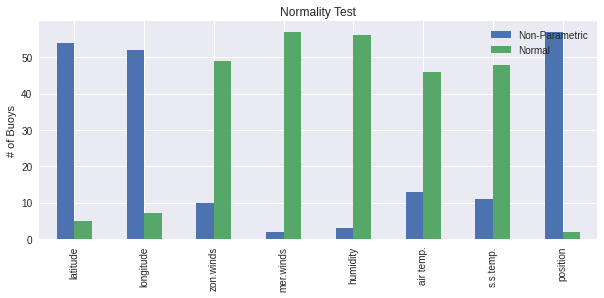

In [12]:
#plotting counts based on the results of the shapiro normality test
plot_normality_data_counts = pd.DataFrame(columns = normality_data.columns, index = ['Non-Parametric', 'Normal'])

for data in normality_data.columns:
    plot_normality_data_counts[data] = normality_data[data].value_counts()

plt.figure()
plot_normality_data_counts = plot_normality_data_counts.T
plt.style.use('seaborn')
plot_normality_data_counts.plot(kind = 'bar', figsize = (10, 4), title = "Normality Test")
plt.ylabel("# of Buoys")

* The resulting Normality Test data was quite intriguing, here we can see that each attribute was categorized by an overwhelming majority towards either Parametric (or Normal) and Nob-Parametric  

* Given that latitude, and longitude were strategically placed, and were not the result of natural phenomena leads some conclusion on the basis for the non parametric skewness of each buoys data set.  

* The data attributes-zonal winds, meridonal winds, humidity, air temperature, and sub surface temperature were the result of natural phenomena such as the El Nino effect, and illustrated by mass congregation of Normality within each buoy's data set.  

In [ ]:
correlation_matrix = pd.DataFrame(index = myData.index.unique(), columns = ['humidity~air temp.', 'humidity~s.s.temp.', 'position~humidity', 'position~air temp.', 'position~s.s.temp.'])
plot_normality_data_counts.head()

,Non Parametric,Normal
latitude,54,5
longitude,52,7
zon.winds,10,49
mer.winds,2,57
humidity,3,56
